In [3]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import laplacian_kernel
from scipy.stats import sem, t
#from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import shap
import optuna

In [4]:
dbnsfp_data = '../dbNSFP/dbNSFP4.8a_variant.disorder_genes.tsv'
AF2_disorder_data = '../output/AF2_disorder_albatross_features_CLNREVSTAT.csv'
refseq_enst_data = '../gene2refseq/mart_export.ensemble_refseq.mapping.tsv'
ref_ps_data = '../alphafold/ref_disorder_phase_separation.tsv'
mut_ps_data = '../alphafold/mut_disorder_phase_separation.tsv'

In [5]:
AF2_df = pd.read_csv(AF2_disorder_data)
mane_df = pd.read_csv(refseq_enst_data, sep='\t')
mane_df = mane_df[['Transcript_stable_ID_version', 'MANE_Select']]
AF2_df = pd.merge(AF2_df, mane_df, left_on='CAVA_TRANSCRIPT', right_on='MANE_Select', how='left')


In [6]:
def preprocess_dbNSFP(dbNSFP_df, gene, transcript):
    required_columns = ['aaref', 'aaalt', 'aapos', 'genename', 'Ensembl_transcriptid',
                        'gnomAD_exomes_AC', 'gnomAD_exomes_AN', 'gnomAD_exomes_AF',
                        'clinvar_clnsig']

    is_rankscore_column = [column for column in dbNSFP_df.columns if column.endswith('rankscore')]
    required_columns += is_rankscore_column

    dbNSFP_req_df = dbNSFP_df[required_columns].copy()

    dbNSFP_req_df.loc[:, 'aapos'] = dbNSFP_req_df['aapos'].str.split(';')
    dbNSFP_req_df.loc[:, 'Ensembl_transcriptid'] = dbNSFP_req_df['Ensembl_transcriptid'].str.split(';')
    dbNSFP_req_df.loc[:, 'genename'] = dbNSFP_req_df['genename'].str.split(';')

    columns_to_explode = ['aapos', 'Ensembl_transcriptid', 'genename']
    dbNSFP_req_df = dbNSFP_req_df.apply(lambda x: x.explode() if x.name in columns_to_explode else x)

    dbNSFP_req_df = dbNSFP_req_df[
        (dbNSFP_req_df['genename'] == gene) & 
        (dbNSFP_req_df['Ensembl_transcriptid'] == transcript)
    ]

    dbNSFP_req_df = dbNSFP_req_df[~dbNSFP_req_df['aapos'].isna()]
    dbNSFP_req_df.loc[:, 'aapos'] = dbNSFP_req_df['aapos'].astype(int)
    dbNSFP_req_df = dbNSFP_req_df[dbNSFP_req_df['aapos'] >= 0]
    dbNSFP_req_df.loc[:, 'aapos'] = dbNSFP_req_df['aapos'].astype(str)

    dbNSFP_req_df.loc[:, 'mutations'] = (
        dbNSFP_req_df['aaref'] + dbNSFP_req_df['aapos'] + dbNSFP_req_df['aaalt']
    )
 
    dbNSFP_req_df = dbNSFP_req_df.replace(".", np.nan)
    dbNSFP_req_df.loc[:, 'aapos'] = dbNSFP_req_df['aapos'].astype(int)
    columns_to_fillna = ['gnomAD_exomes_AC', 'gnomAD_exomes_AN', 'gnomAD_exomes_AF', 'clinvar_clnsig'] + is_rankscore_column
    dbNSFP_req_df.loc[:, columns_to_fillna] = dbNSFP_req_df[columns_to_fillna].fillna(0)

    dbNSFP_req_df = dbNSFP_req_df.drop_duplicates().reset_index(drop=True)

    return dbNSFP_req_df

In [7]:
dbnsfp_df = pd.read_csv(dbnsfp_data, sep='\t')
dbnsfpt_gene_df = pd.read_csv("../alphafold/dbNSFP_disorder_genes.tsv", sep='\t')

/tmp/ipykernel_2173979/1651565.py:1: DtypeWarning: Columns (0,1,7,8,9,10,11,26,30,31,40,41,49,50,52,53,54,58,59,61,62,64,65,67,68,69,70,72,73,75,76,77,82,83,91,92,98,99,101,102,104,105,107,108,110,111,113,114,115,116,117,118,119,120,121,122,140,141,142,143,150,151,152,153,154,155,156,157,158,159,162,163,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,192,193,194,195,196,197,198,199,200,201,202,203,205,206,207,208) have mixed types. Specify dtype option on import or set low_memory=False.
  dbnsfp_df = pd.read_csv(dbnsfp_data, sep='\t')


In [8]:
AF2_keep_df = AF2_df[AF2_df['Class'] != 'VUS']
AF2_keep_df['label']= AF2_keep_df["Class"].map({"Deleterious": 1, "Neutral": 0})

In [9]:
# Extract unique gene names from each DataFrame
genes_af2 = set(AF2_keep_df['GENES'].unique())  # Genes from AF2_keep_df
genes_dbnsfp = set(dbnsfpt_gene_df['genename'].unique())  # Genes from dbnsfpt_gene_df

# Find genes that are unique to AF2_keep_df
unique_genes_af2 = genes_af2 - genes_dbnsfp


In [10]:
# Extract relevant predictor columns
dbnsfp_predictors = [column for column in dbnsfpt_gene_df.columns if column.endswith('rankscore')]

# Merge AF2_df with dbNSFP data
AF2_disorder_dbnsfp_df = pd.merge(
    AF2_keep_df, dbnsfpt_gene_df, left_on=['GENES', 'mutation'], right_on=['genename', 'mutations'], how='left'
)
AF2_disorder_dbnsfp_df = AF2_disorder_dbnsfp_df.groupby(['mutations', 'GENES', 'label']).first().reset_index()

existing_rankscore_columns = [col for col in dbnsfp_predictors if col in AF2_disorder_dbnsfp_df.columns]
existing_rankscore_columns = existing_rankscore_columns + ['mutations', 'GENES', 'label']

AF2_disorder_dbnsfp_pred_df = AF2_disorder_dbnsfp_df[existing_rankscore_columns].dropna().reset_index(drop=True)

AF2_disorder_dbnsfp_df.to_csv("../output/data_used_study.csv", index=False)

In [11]:
group_bar_df = AF2_disorder_dbnsfp_df[['GENES', 'Class']]
group_bar_counts = pd.crosstab(index=group_bar_df["GENES"], columns=group_bar_df["Class"]).reset_index()
group_bar_counts.to_csv("../output/data_genes_count.csv", index=False)

In [12]:
AF2_disorder_dbnsfp_pred_df.to_csv("../output/mutation_data_with_dnsfp_scores.csv", index=None)
duplicate_counts = AF2_disorder_dbnsfp_pred_df.groupby(['mutations', 'GENES', 'label']).size().reset_index(name='count')
duplicates = duplicate_counts[duplicate_counts['count'] > 1]

In [13]:
def calculate_auc_with_ci(df, column, label, random_state=42, n_bootstrap=1000):
    """
    Calculate AUC and PR-AUC with confidence intervals using natural bootstrap sampling.
    This maintains the original class distribution and doesn't artificially balance classes.
    """
    np.random.seed(random_state)  # Set the seed for reproducibility
    
    aucs = []
    pr_aucs = []
    
    # Clean the data first
    clean_df = df.dropna(subset=[label, column])
    if clean_df.empty:
        raise ValueError("No valid data after removing NaN values")
    
    print(f"Sample size: {len(clean_df)}")
    print(f"Class distribution: {dict(zip(*np.unique(clean_df[label], return_counts=True)))}")
    
    for i in range(n_bootstrap):
        # Natural bootstrap: sample with replacement maintaining original distribution
        bootstrap_sample = clean_df.sample(n=len(clean_df), replace=True, random_state=random_state+i)
        
        # Extract labels and predictions
        y_true = bootstrap_sample[label].values
        y_pred = bootstrap_sample[column].values
        
        # Skip if only one class present in bootstrap sample
        if len(np.unique(y_true)) < 2:
            continue
            
        try:
            # Calculate AUC and PR AUC
            auc = roc_auc_score(y_true, y_pred)
            aucs.append(auc)
            
            pr_auc = average_precision_score(y_true, y_pred)
            pr_aucs.append(pr_auc)
            
        except ValueError as e:
            # Skip problematic bootstrap samples
            continue
    
    if len(aucs) == 0 or len(pr_aucs) == 0:
        raise ValueError("No valid bootstrap samples generated")
    
    # Calculate Confidence Intervals using percentile method (more robust than t-distribution)
    auc_mean = np.mean(aucs)
    auc_ci_lower = np.percentile(aucs, 2.5)
    auc_ci_upper = np.percentile(aucs, 97.5)
    
    pr_auc_mean = np.mean(pr_aucs)
    pr_auc_ci_lower = np.percentile(pr_aucs, 2.5)
    pr_auc_ci_upper = np.percentile(pr_aucs, 97.5)
    
    print(f"Bootstrap samples used: AUC={len(aucs)}, PR-AUC={len(pr_aucs)}")
    
    return {
        'auc_mean': auc_mean,
        'auc_ci': (auc_ci_lower, auc_ci_upper),
        'pr_auc_mean': pr_auc_mean,
        'pr_auc_ci': (pr_auc_ci_lower, pr_auc_ci_upper),
        'n_bootstrap_used': len(aucs)
    }

def calculate_metrics_and_store(results_df, predictors, label_col, result_type, n_bootstrap=1000):
    """
    Calculate natural bootstrap metrics for multiple predictors and store in DataFrame.
    
    Args:
        results_df: DataFrame containing the data
        predictors: List of predictor column names
        label_col: Name of the label column
        result_type: String identifier for the type of results
        n_bootstrap: Number of bootstrap iterations
    
    Returns:
        DataFrame with results sorted by AUC
    """
    data_dict = {
        'name': [], 
        'AUC': [], 
        'AUC_CI_low': [], 
        'AUC_CI_high': [], 
        'PR_AUC': [],
        'PR_AUC_CI_low': [], 
        'PR_AUC_CI_high': [],
        'AUC_CI_width': [],
        'PR_AUC_CI_width': [],
        'n_bootstrap_used': [],
        'TYPE': []
    }
    
    for predictor in predictors:
        print(f"\n=== Calculating metrics for {predictor} ===")
        
        try:
            # Call the function to calculate metrics
            results = calculate_auc_with_ci(
                results_df, predictor, label_col, n_bootstrap=n_bootstrap
            )
            
            # Store the calculated values in the dictionary
            data_dict['name'].append(predictor)
            data_dict['AUC'].append(results['auc_mean'])
            data_dict['AUC_CI_low'].append(results['auc_ci'][0])
            data_dict['AUC_CI_high'].append(results['auc_ci'][1])
            data_dict['PR_AUC'].append(results['pr_auc_mean'])
            data_dict['PR_AUC_CI_low'].append(results['pr_auc_ci'][0])
            data_dict['PR_AUC_CI_high'].append(results['pr_auc_ci'][1])
            data_dict['AUC_CI_width'].append(results['auc_ci'][1] - results['auc_ci'][0])
            data_dict['PR_AUC_CI_width'].append(results['pr_auc_ci'][1] - results['pr_auc_ci'][0])
            data_dict['n_bootstrap_used'].append(results['n_bootstrap_used'])
            data_dict['TYPE'].append(result_type)
            
            print(f"✓ Success: AUC={results['auc_mean']:.3f} [{results['auc_ci'][0]:.3f}, {results['auc_ci'][1]:.3f}]")
            print(f"✓ Success: PR-AUC={results['pr_auc_mean']:.3f} [{results['pr_auc_ci'][0]:.3f}, {results['pr_auc_ci'][1]:.3f}]")
            
        except Exception as e:
            print(f"✗ Error processing {predictor}: {str(e)}")
            # Still add the predictor but with NaN values
            data_dict['name'].append(predictor)
            data_dict['AUC'].append(np.nan)
            data_dict['AUC_CI_low'].append(np.nan)
            data_dict['AUC_CI_high'].append(np.nan)
            data_dict['PR_AUC'].append(np.nan)
            data_dict['PR_AUC_CI_low'].append(np.nan)
            data_dict['PR_AUC_CI_high'].append(np.nan)
            data_dict['AUC_CI_width'].append(np.nan)
            data_dict['PR_AUC_CI_width'].append(np.nan)
            data_dict['n_bootstrap_used'].append(0)
            data_dict['TYPE'].append(result_type)
    
    # Convert the dictionary into a DataFrame and return it sorted by AUC
    result_df = pd.DataFrame(data_dict)
    result_df = result_df.sort_values(by="AUC", ascending=False)
    
    return result_df

In [14]:
dbnsfp_predictors =  [column for column in AF2_disorder_dbnsfp_pred_df.columns if column.endswith('rankscore')]

AF2_disorder_dbnsfp_pred_df[dbnsfp_predictors] = AF2_disorder_dbnsfp_pred_df[dbnsfp_predictors].astype(float)
result_disorder_df = calculate_metrics_and_store(AF2_disorder_dbnsfp_pred_df, dbnsfp_predictors, 'label', 'dbNSFP Predictor')



=== Calculating metrics for SIFT_converted_rankscore ===
Sample size: 2104
Class distribution: {0: 1788, 1: 316}
Bootstrap samples used: AUC=1000, PR-AUC=1000
✓ Success: AUC=0.830 [0.806, 0.854]
✓ Success: PR-AUC=0.454 [0.403, 0.502]

=== Calculating metrics for SIFT4G_converted_rankscore ===
Sample size: 2104
Class distribution: {0: 1788, 1: 316}
Bootstrap samples used: AUC=1000, PR-AUC=1000
✓ Success: AUC=0.800 [0.773, 0.824]
✓ Success: PR-AUC=0.429 [0.378, 0.478]

=== Calculating metrics for Polyphen2_HDIV_rankscore ===
Sample size: 2104
Class distribution: {0: 1788, 1: 316}
Bootstrap samples used: AUC=1000, PR-AUC=1000
✓ Success: AUC=0.829 [0.805, 0.852]
✓ Success: PR-AUC=0.431 [0.385, 0.478]

=== Calculating metrics for Polyphen2_HVAR_rankscore ===
Sample size: 2104
Class distribution: {0: 1788, 1: 316}
Bootstrap samples used: AUC=1000, PR-AUC=1000
✓ Success: AUC=0.844 [0.821, 0.867]
✓ Success: PR-AUC=0.517 [0.464, 0.571]

=== Calculating metrics for LRT_converted_rankscore ===
S

In [15]:
result_disorder_df.to_csv("../output/dbnsfp_results.csv", index=None)



=== Calculating metrics for SIFT_converted_rankscore ===
Sample size: 2104
Class distribution: {0: 1788, 1: 316}
Bootstrap samples used: AUC=1000, PR-AUC=1000
✓ Success: AUC=0.830 [0.806, 0.854]
✓ Success: PR-AUC=0.454 [0.403, 0.502]

=== Calculating metrics for SIFT4G_converted_rankscore ===
Sample size: 2104
Class distribution: {0: 1788, 1: 316}
Bootstrap samples used: AUC=1000, PR-AUC=1000
✓ Success: AUC=0.800 [0.773, 0.824]
✓ Success: PR-AUC=0.429 [0.378, 0.478]

=== Calculating metrics for Polyphen2_HDIV_rankscore ===
Sample size: 2104
Class distribution: {0: 1788, 1: 316}
Bootstrap samples used: AUC=1000, PR-AUC=1000
✓ Success: AUC=0.829 [0.805, 0.852]
✓ Success: PR-AUC=0.431 [0.385, 0.478]

=== Calculating metrics for Polyphen2_HVAR_rankscore ===
Sample size: 2104
Class distribution: {0: 1788, 1: 316}
Bootstrap samples used: AUC=1000, PR-AUC=1000
✓ Success: AUC=0.844 [0.821, 0.867]
✓ Success: PR-AUC=0.517 [0.464, 0.571]

=== Calculating metrics for LRT_converted_rankscore ===
S

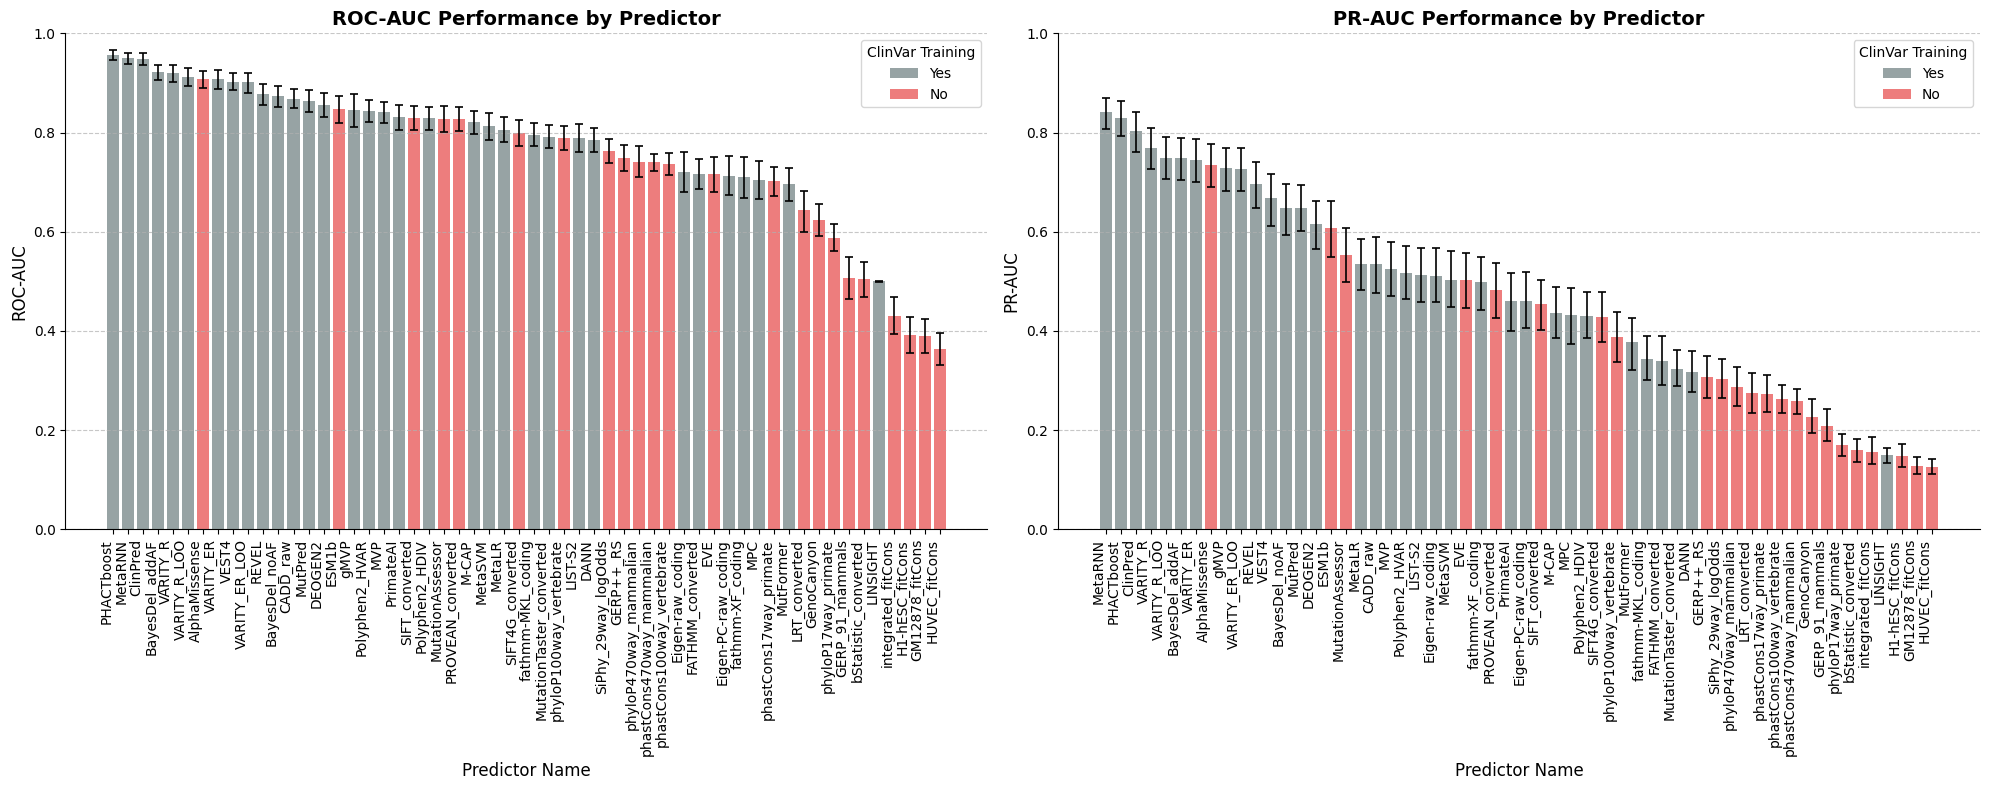

In [16]:
dbnsfp_predictors = [column for column in AF2_disorder_dbnsfp_pred_df.columns if column.endswith('rankscore')]
AF2_disorder_dbnsfp_pred_df[dbnsfp_predictors] = AF2_disorder_dbnsfp_pred_df[dbnsfp_predictors].astype(float)
result_disorder_df = calculate_metrics_and_store(AF2_disorder_dbnsfp_pred_df, dbnsfp_predictors, 'label', 'dbNSFP Predictor')

non_clinvar = ['AlphaMissense_rankscore','SIFT_converted_rankscore', 'SIFT4G_converted_rankscore',
               'LRT_converted_rankscore', 'PROVEAN_converted_rankscore', 'MutationAssessor_rankscore', 'GenoCanyon_rankscore',
                     'ESM1b_rankscore', 'EVE_rankscore','integrated_fitCons_rankscore', 'GM12878_fitCons_rankscore',
                     'H1-hESC_fitCons_rankscore', 'HUVEC_fitCons_rankscore','GERP++_RS_rankscore',
                     'GERP_91_mammals_rankscore','phyloP100way_vertebrate_rankscore',
                     'phyloP470way_mammalian_rankscore','phyloP17way_primate_rankscore',
                     'phastCons100way_vertebrate_rankscore',
                     'phastCons470way_mammalian_rankscore','phastCons17way_primate_rankscore','SiPhy_29way_logOdds_rankscore',
                     'bStatistic_converted_rankscore']

# Create a new column to define colors based on the unsupervised list
result_disorder_df['Clinvar'] = result_disorder_df['name'].apply(
    lambda x: 'No' if x in non_clinvar else 'Yes'
)
result_disorder_df['name'] = result_disorder_df['name'].str.replace('_rankscore', '', regex=False)
print(result_disorder_df)
# Sort by AUC for better visualization
result_disorder_df = result_disorder_df.sort_values('AUC', ascending=False)

# Create subplots for both AUC and PR-AUC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Color palette
palette = {"No": "#FF6B6B", "Yes": "#95A5A6"}

# Plot 1: AUC
sns.barplot(
    data=result_disorder_df, 
    x='name', 
    y='AUC', 
    hue='Clinvar', 
    dodge=False, 
    errorbar=None, 
    palette=palette,
    ax=ax1
)

# Add error bars for AUC
x_coords_auc = np.arange(len(result_disorder_df))
y_values_auc = result_disorder_df['AUC'].values
y_err_lower_auc = (result_disorder_df['AUC'] - result_disorder_df['AUC_CI_low']).values
y_err_upper_auc = (result_disorder_df['AUC_CI_high'] - result_disorder_df['AUC']).values

ax1.errorbar(
    x=x_coords_auc, 
    y=y_values_auc, 
    yerr=[y_err_lower_auc, y_err_upper_auc], 
    fmt='none', ecolor='black', capsize=3, elinewidth=1.2, capthick=1.2
)

# Format AUC plot
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha="right")
ax1.set_xlabel("Predictor Name", fontsize=12)
ax1.set_ylabel("ROC-AUC", fontsize=12)
ax1.set_title("ROC-AUC Performance by Predictor", fontsize=14, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(title="ClinVar Training", loc='upper right')
ax1.set_ylim(0, 1)

# Plot 2: PR-AUC
# Sort by PR-AUC for the second plot
result_disorder_df_pr = result_disorder_df.sort_values('PR_AUC', ascending=False)

sns.barplot(
    data=result_disorder_df_pr, 
    x='name', 
    y='PR_AUC', 
    hue='Clinvar', 
    dodge=False, 
    errorbar=None, 
    palette=palette,
    ax=ax2
)

# Add error bars for PR-AUC
x_coords_pr = np.arange(len(result_disorder_df_pr))
y_values_pr = result_disorder_df_pr['PR_AUC'].values
y_err_lower_pr = (result_disorder_df_pr['PR_AUC'] - result_disorder_df_pr['PR_AUC_CI_low']).values
y_err_upper_pr = (result_disorder_df_pr['PR_AUC_CI_high'] - result_disorder_df_pr['PR_AUC']).values

ax2.errorbar(
    x=x_coords_pr, 
    y=y_values_pr, 
    yerr=[y_err_lower_pr, y_err_upper_pr], 
    fmt='none', ecolor='black', capsize=3, elinewidth=1.2, capthick=1.2
)

# Format PR-AUC plot
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha="right")
ax2.set_xlabel("Predictor Name", fontsize=12)
ax2.set_ylabel("PR-AUC", fontsize=12)
ax2.set_title("PR-AUC Performance by Predictor", fontsize=14, fontweight='bold')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend(title="ClinVar Training", loc='upper right')
ax2.set_ylim(0, 1)

# Overall formatting
plt.tight_layout()
sns.despine()

# Save both plots
plt.savefig("AUC_and_PR_AUC_dbsnsfp_disorder.png", dpi=300, bbox_inches='tight')
plt.show()

# Optional: Create individual plots if you prefer separate figures
def create_individual_plots():
    """Create separate individual plots for AUC and PR-AUC"""
    
    # Individual AUC plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=result_disorder_df, 
        x='name', 
        y='AUC', 
        hue='Clinvar', 
        dodge=False, 
        errorbar=None, 
        palette={"Unsupervised": "red", "Supervised": "grey"}
    )
    
    # Add error bars
    x_coords = np.arange(len(result_disorder_df))
    y_values = result_disorder_df['AUC'].values
    y_err_lower = (result_disorder_df['AUC'] - result_disorder_df['AUC_CI_low']).values
    y_err_upper = (result_disorder_df['AUC_CI_high'] - result_disorder_df['AUC']).values
    
    plt.errorbar(
        x=x_coords, 
        y=y_values, 
        yerr=[y_err_lower, y_err_upper], 
        fmt='none', ecolor='black', capsize=3, elinewidth=1.2, capthick=1.2
    )
    
    plt.xticks(rotation=90, ha="right")
    plt.xlabel("Predictor Name", fontsize=12)
    plt.ylabel("AUC", fontsize=12)
    plt.title("ROC-AUC Performance by Predictor", fontsize=14, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.8)
    plt.legend(title="ClinVar Training")
    plt.ylim(0, 1)
    sns.despine()
    plt.tight_layout()
    plt.savefig("AUC_dbsnsfp_disorder.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Individual PR-AUC plot
    plt.figure(figsize=(12, 6))
    result_disorder_df_pr_sorted = result_disorder_df.sort_values('PR_AUC', ascending=False)
    
    ax = sns.barplot(
        data=result_disorder_df_pr_sorted, 
        x='name', 
        y='PR_AUC', 
        hue='Clinvar', 
        dodge=False, 
        errorbar=None, 
        palette={"Unsupervised": "red", "Supervised": "grey"}
    )
    
    # Add error bars
    x_coords = np.arange(len(result_disorder_df_pr_sorted))
    y_values = result_disorder_df_pr_sorted['PR_AUC'].values
    y_err_lower = (result_disorder_df_pr_sorted['PR_AUC'] - result_disorder_df_pr_sorted['PR_AUC_low']).values
    y_err_upper = (result_disorder_df_pr_sorted['PR_AUC_high'] - result_disorder_df_pr_sorted['PR_AUC']).values
    
    plt.errorbar(
        x=x_coords, 
        y=y_values, 
        yerr=[y_err_lower, y_err_upper], 
        fmt='none', ecolor='black', capsize=3, elinewidth=1.2, capthick=1.2
    )
    
    plt.xticks(rotation=90, ha="right")
    plt.xlabel("Predictor Name", fontsize=12)
    plt.ylabel("PR-AUC", fontsize=12)
    plt.title("PR-AUC Performance by Predictor", fontsize=14, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.8)
    plt.legend(title="ClinVar Training")
    plt.ylim(0, 1)
    sns.despine()
    plt.tight_layout()
    plt.savefig("PR_AUC_dbsnsfp_disorder.png", dpi=300, bbox_inches='tight')
    plt.show()


/tmp/ipykernel_2173979/3760741073.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_disorder_supervised_df['is_supervised'] = result_disorder_df['name'].apply(


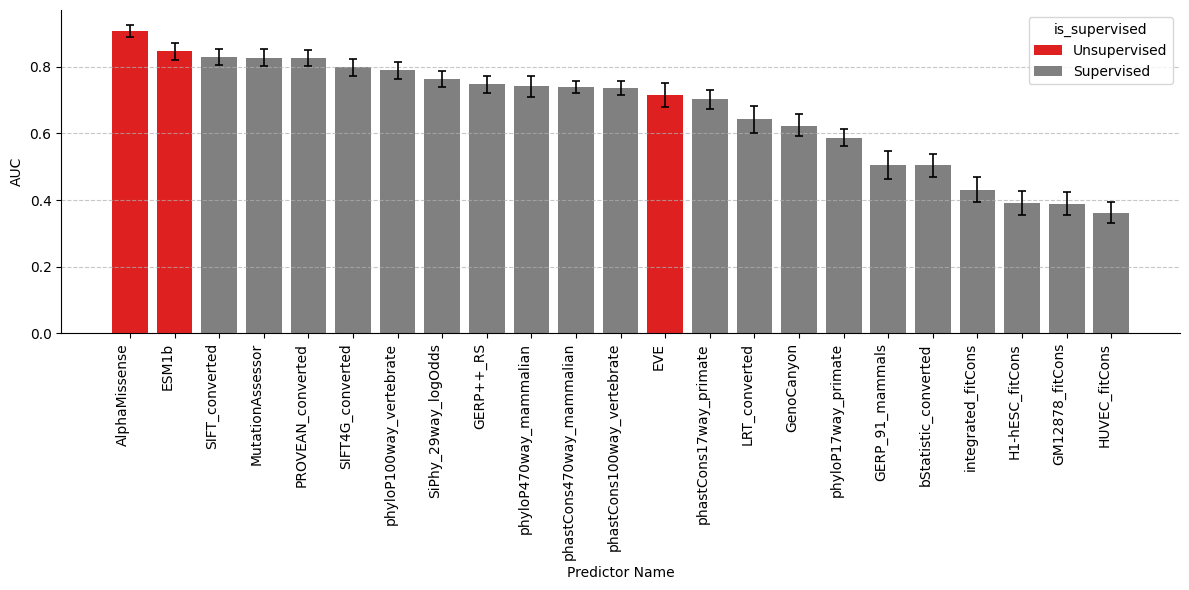

In [17]:
unsupervised_list = ['AlphaMissense', 'ESM1b', "EVE"]

result_disorder_supervised_df = result_disorder_df[result_disorder_df['Clinvar'] == 'No']
result_disorder_supervised_df['is_supervised'] = result_disorder_df['name'].apply(
    lambda x: 'Unsupervised' if x in unsupervised_list else 'Supervised'
)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=result_disorder_supervised_df, 
    x='name', 
    y='AUC', 
    hue='is_supervised', 
    dodge=False, 
    errorbar=None, palette={"Unsupervised": "red", "Supervised": "grey"}
)

# Ensure x-coordinates match the number of bars
x_coords = np.arange(len(result_disorder_supervised_df))  # Numeric x-axis positions
y_values = result_disorder_supervised_df['AUC'].values
y_err_lower = (result_disorder_supervised_df['AUC'] - result_disorder_supervised_df['AUC_CI_low']).values
y_err_upper = (result_disorder_supervised_df['AUC_CI_high'] - result_disorder_supervised_df['AUC']).values

plt.errorbar(
    x=x_coords, 
    y=y_values, 
    yerr=[y_err_lower, y_err_upper], 
    fmt='none', ecolor='black', capsize=3, elinewidth=1.2, capthick=1.2
)

# Formatting
plt.xticks(rotation=90, ha="right")
plt.xlabel("Predictor Name")
plt.ylabel("AUC")
#plt.title("AUC for mutations in disordered regions")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="is_supervised")
sns.despine()
plt.tight_layout()
plt.savefig("AUC_dbsnsfp_disorder_unsupervised.png", dpi=300)
# Show plot
plt.show()

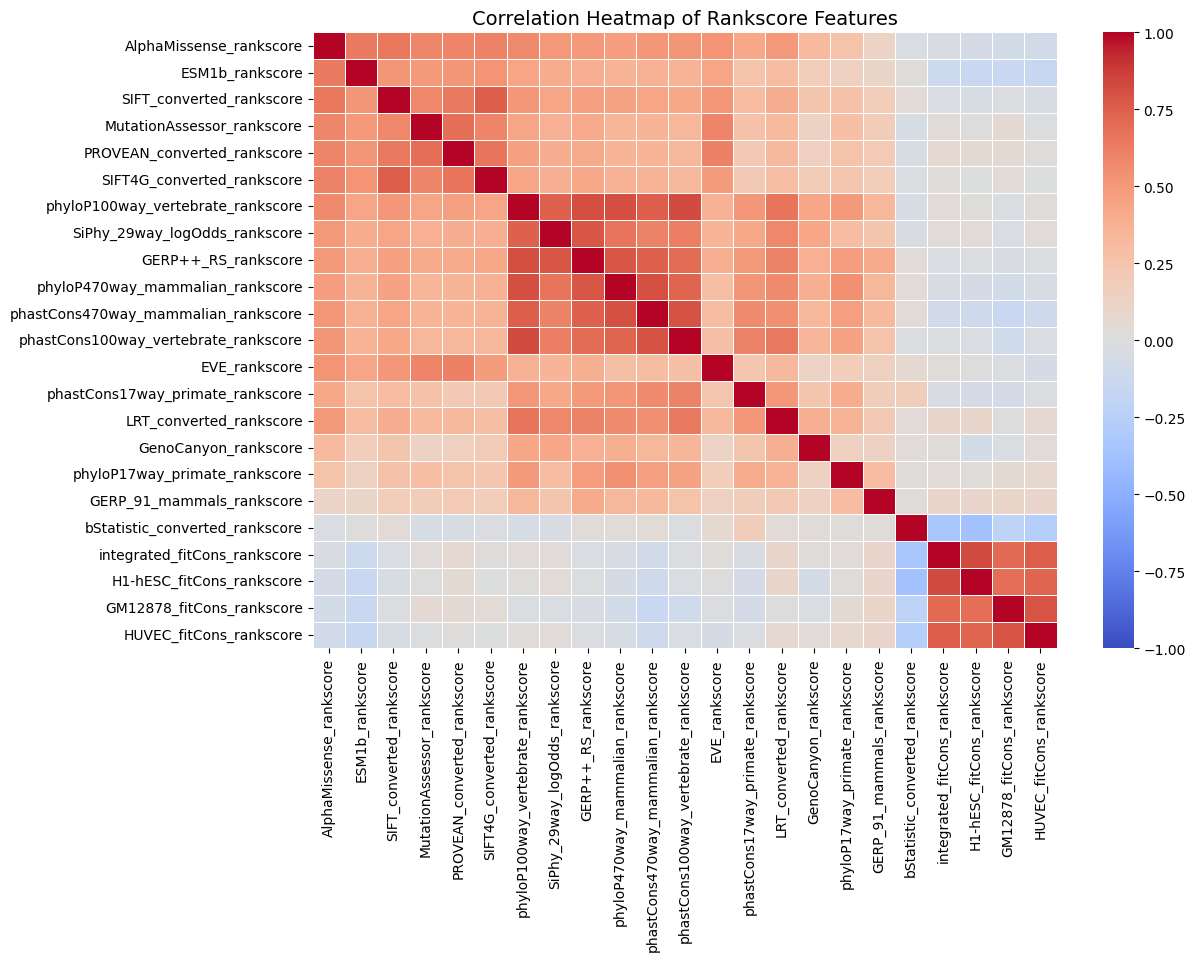

In [18]:
col_name = [i + "_rankscore" for i in result_disorder_supervised_df.name.tolist()]

#AF2_disorder_dbnsfp_pred_df[col_name]
selected_df = AF2_disorder_dbnsfp_pred_df[col_name]

# Compute the correlation matrix
corr_matrix = selected_df.corr()

# Set up the figure size
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(
    corr_matrix, 
    annot=False,  # Show correlation values
    fmt=".2f",  # Limit decimal places
    cmap="coolwarm",  # Choose color scheme
    linewidths=0.5,  # Add grid lines
    vmin=-1, vmax=1  # Set correlation range
)

# Set title
plt.title("Correlation Heatmap of Rankscore Features", fontsize=14)

# Show the plot
plt.show()

In [19]:
AF2_disorder_dbnsfp_insilico_df = AF2_disorder_dbnsfp_df[['AlphaMissense_rankscore', 'ESM1b_rankscore', 'EVE_rankscore', 'mutation', 'Class', 'WT', 'mut_seq',
                                                          'abs_delta_asphericity', 'abs_delta_radius_of_gyration',
                                                          'abs_delta_end_to_end_distance','abs_delta_scaling_exponent','abs_delta_prefactor',
                                                          'integrated_fitCons_rankscore',
                                                          'GM12878_fitCons_rankscore',
                                                          'H1-hESC_fitCons_rankscore',
                                                          'HUVEC_fitCons_rankscore',
                                                          'LINSIGHT_rankscore','GERP++_RS_rankscore',
                                                          'GERP_91_mammals_rankscore',
                                                          'phyloP100way_vertebrate_rankscore',
                                                          'phyloP470way_mammalian_rankscore',
                                                          'phyloP17way_primate_rankscore',
                                                          'phastCons100way_vertebrate_rankscore',
                                                          'phastCons470way_mammalian_rankscore',
                                                          'phastCons17way_primate_rankscore',
                                                          'SiPhy_29way_logOdds_rankscore','bStatistic_converted_rankscore','label', 'GENES']]

AF2_disorder_dbnsfp_insilico_df

,AlphaMissense_rankscore,ESM1b_rankscore,EVE_rankscore,mutation,Class,WT,mut_seq,abs_delta_asphericity,abs_delta_radius_of_gyration,abs_delta_end_to_end_distance,...,phyloP100way_vertebrate_rankscore,phyloP470way_mammalian_rankscore,phyloP17way_primate_rankscore,phastCons100way_vertebrate_rankscore,phastCons470way_mammalian_rankscore,phastCons17way_primate_rankscore,SiPhy_29way_logOdds_rankscore,bStatistic_converted_rankscore,label,GENES
0,0.32275,0.08491,0.39711,A1011E,Neutral,DLYGRLEKDGLLKKLEEEKAEAAEAAEERLDCCNDGCSDSMVGHNE...,DLYGRLEKDGLLKKLEEEKAEAAEAAEERLDCCNDGCSDSMVGHNE...,0.000456,0.017019,0.131171,...,0.34025,0.35768,0.76740,0.32681,0.30280,0.91618,0.51303,0.20147,0,TSC1
1,0.21163,0.31818,0.00000,A102T,Neutral,MALAGAPAGGPCAPALEALLGAGALRLLDSSQIVIISAAQDASAPP...,MALAGAPAGGPCAPALEALLGAGALRLLDSSQIVIISAAQDASAPP...,0.000393,0.013586,0.058442,...,0.38254,0.50968,0.40250,0.36153,0.68203,0.42306,0.72029,0.94257,0,E2F1
2,0.05404,0.20700,0.30810,A1034T,Neutral,PNMERMSLKTRLALLGDALEPGVALPPVHAPRRCSDGGAHGYGRRH...,PNMERMSLKTRLALLGDALEPGVALPPVHAPRRCSDGGAHGYGRRH...,0.000208,0.005768,0.008315,...,0.32736,0.23892,0.32500,0.06391,0.08366,0.02609,0.47052,0.14249,0,GLI3
3,0.01762,0.25569,0.10646,A1039T,Neutral,PNMERMSLKTRLALLGDALEPGVALPPVHAPRRCSDGGAHGYGRRH...,PNMERMSLKTRLALLGDALEPGVALPPVHAPRRCSDGGAHGYGRRH...,0.000060,0.015663,0.013506,...,0.07188,0.12261,0.09497,0.06391,0.08366,0.02609,0.03380,0.14249,0,GLI3
4,0.12037,0.32159,0.00000,A103V,Neutral,MAAADAEAVPARGEPQQDCCVKTELLGEETPMAADEGSAEKQAGEA...,MAAADAEAVPARGEPQQDCCVKTELLGEETPMAADEGSAEKQAGEA...,0.000043,0.013189,0.062256,...,0.05933,0.04170,0.09056,0.06391,0.08366,0.32885,0.85864,0.03397,0,EHMT1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,0.81604,0.92375,0.97423,Y828C,Deleterious,ATQETSTVRLKVSSTAVRTQHTTTRPVPDTSRLPGATPGLTTVEIV...,ATQETSTVRLKVSSTAVRTQHTTTRPVPDTSRLPGATPGLTTVEIV...,0.001576,0.275188,0.814741,...,0.93611,0.00000,0.85281,0.71638,0.68203,0.46843,0.61667,0.74455,1,LDLR
2100,0.75067,0.85340,0.95643,Y828H,Deleterious,ATQETSTVRLKVSSTAVRTQHTTTRPVPDTSRLPGATPGLTTVEIV...,ATQETSTVRLKVSSTAVRTQHTTTRPVPDTSRLPGATPGLTTVEIV...,0.001318,0.192311,0.475619,...,0.85003,0.00000,0.49286,0.71638,0.68203,0.46004,0.61667,0.74455,1,LDLR
2101,0.74324,0.98502,0.96887,Y828S,Deleterious,ATQETSTVRLKVSSTAVRTQHTTTRPVPDTSRLPGATPGLTTVEIV...,ATQETSTVRLKVSSTAVRTQHTTTRPVPDTSRLPGATPGLTTVEIV...,0.001424,0.276003,0.796033,...,0.93611,0.00000,0.85281,0.71638,0.68203,0.46843,0.61667,0.74455,1,LDLR
2102,0.54346,0.13201,0.49012,Y856H,Neutral,NSYNFAKKENNSPEHLKDEVSIIQSMGYRNRAKRLLQSEPENPSLQ...,NSYNFAKKENNSPEHLKDEVSIIQSMGYRNRAKRLLQSEPENPSLQ...,0.000180,0.254652,0.531122,...,0.50987,0.29374,0.84096,0.71638,0.31174,0.71098,0.46289,0.75131,0,BRCA1


In [20]:
def compute_metrics_cv(dataframe, predictor_col, class_col, n_splits=10, random_state=None):
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Prepare metrics storage
    metrics_list = []
    
    # Extract predictor and class columns
    X = dataframe[predictor_col].values.astype(float)  # Ensure predictor is float
    y = dataframe[class_col].values
    
    # Print overall class distribution
    unique_classes, overall_counts = np.unique(y, return_counts=True)
    print(f"Overall dataset class distribution:")
    for cls, count in zip(unique_classes, overall_counts):
        print(f"  Class {cls}: {count} samples ({count/len(y)*100:.1f}%)")
    print(f"Total samples: {len(y)}")
    print("-" * 50)
    
    # Iterate through the random folds
    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        # Split the data into train and test sets
        y_true = y[test_index]
        y_pred = X[test_index]
        
        # Count classes in this fold
        unique_test, test_counts = np.unique(y_true, return_counts=True)
        class_0_count = test_counts[unique_test == 0][0] if 0 in unique_test else 0
        class_1_count = test_counts[unique_test == 1][0] if 1 in unique_test else 0
        
        print(f"Fold {fold} test set - Class 0: {class_0_count}, Class 1: {class_1_count}")
        
        # Calculate metrics
        if len(np.unique(y_true)) == 1:
            # Skip fold if the test set has only one class
            print(f"  Skipping fold {fold} - only one class present")
            continue
            
        auc = roc_auc_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, np.round(y_pred))
        pr_auc = average_precision_score(y_true, y_pred)
        
        # Store metrics with class counts
        metrics_list.append({
            'fold': fold,
            'auc': auc,
            'accuracy': accuracy,
            'pr_auc': pr_auc,
            'class_0_count': class_0_count,
            'class_1_count': class_1_count,
            'total_test_samples': len(y_true),
            'class_1_percentage': (class_1_count / len(y_true)) * 100  # NEW: Percentage of class 1 in fold
        })
    
    # Convert metrics to DataFrame
    results_df = pd.DataFrame(metrics_list)
    
    # Print summary statistics
    if not results_df.empty:
        print(f"\n=== Summary Statistics ===")
        print(f"AUC: {results_df['auc'].mean():.4f} ± {results_df['auc'].std():.4f}")
        print(f"PR-AUC: {results_df['pr_auc'].mean():.4f} ± {results_df['pr_auc'].std():.4f}")
        print(f"Accuracy: {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
        print(f"Average test fold size: {results_df['total_test_samples'].mean():.1f}")
        print(f"Average Class 0 per fold: {results_df['class_0_count'].mean():.1f}")
        print(f"Average Class 1 per fold: {results_df['class_1_count'].mean():.1f}")
        print(f"Class 1 percentage range: {results_df['class_1_percentage'].min():.1f}% - {results_df['class_1_percentage'].max():.1f}%")
    
    return results_df

In [21]:
eve_only_df = compute_metrics_cv(AF2_disorder_dbnsfp_insilico_df, predictor_col='EVE_rankscore', 
                                                    class_col='label', n_splits=10, random_state=42)
eve_only_df['method'] = 'EVE'
eve_only_df['model'] = 'EVE'
esm1b_only_df = compute_metrics_cv(AF2_disorder_dbnsfp_insilico_df, predictor_col='ESM1b_rankscore', 
                                   class_col='label', n_splits=10, random_state=42)
esm1b_only_df['method'] = 'ESM1B'
esm1b_only_df['model'] ='ESM1B'

AM_only_df = compute_metrics_cv(AF2_disorder_dbnsfp_insilico_df, predictor_col='AlphaMissense_rankscore', 
                                   class_col='label', n_splits=10, random_state=42)
AM_only_df['method'] = 'AlphaMissense'
AM_only_df['model'] ='AlphaMissense'

Overall dataset class distribution:
  Class 0: 1788 samples (85.0%)
  Class 1: 316 samples (15.0%)
Total samples: 2104
--------------------------------------------------
Fold 1 test set - Class 0: 179, Class 1: 32
Fold 2 test set - Class 0: 179, Class 1: 32
Fold 3 test set - Class 0: 179, Class 1: 32
Fold 4 test set - Class 0: 179, Class 1: 32
Fold 5 test set - Class 0: 179, Class 1: 31
Fold 6 test set - Class 0: 179, Class 1: 31
Fold 7 test set - Class 0: 179, Class 1: 31
Fold 8 test set - Class 0: 179, Class 1: 31
Fold 9 test set - Class 0: 178, Class 1: 32
Fold 10 test set - Class 0: 178, Class 1: 32

=== Summary Statistics ===
AUC: 0.7156 ± 0.0549
PR-AUC: 0.5061 ± 0.0435
Accuracy: 0.8275 ± 0.0183
Average test fold size: 210.4
Average Class 0 per fold: 178.8
Average Class 1 per fold: 31.6
Class 1 percentage range: 14.8% - 15.2%
Overall dataset class distribution:
  Class 0: 1788 samples (85.0%)
  Class 1: 316 samples (15.0%)
Total samples: 2104
--------------------------------------

In [23]:
#AF2_disorder_dbnsfp_insilico_df['size'] = AF2_disorder_dbnsfp_insilico_df['WT'].str.len()
#plot_dist_df = AF2_disorder_dbnsfp_insilico_df[['label', 'size']]
# Rename labels for clarity
#plot_dist_df['label'] = plot_dist_df['label'].replace({1: 'Deleterious', 0: 'Benign'})

# Set figure size
#plt.figure(figsize=(8, 6))

# Create box plot
#sns.boxplot(
#    data=plot_dist_df, 
#    x="label", 
#    y="size",
#    width=0.5,  # Adjust box width
#    fliersize=3,  # Adjust outlier size
#    palette={"Deleterious": "red", "Benign": "lightblue"}  # Custom colors
#)

# Labels and Title
#plt.xlabel("Classification", fontsize=14)
#plt.ylabel("IDR length", fontsize=14)
#plt.title("Box Plot of Size Distribution by Label", fontsize=16)

# Remove top & right spines
#sns.despine()
#plt.savefig("IDR_length_by_type.png", dpi=300)
# Show the plot
#plt.show()

In [24]:
feature_cols_eve = [ 'EVE_rankscore', 
                'abs_delta_asphericity', 'abs_delta_radius_of_gyration',
                'abs_delta_end_to_end_distance','abs_delta_scaling_exponent','abs_delta_prefactor']

feature_cols_esm1b = ['ESM1b_rankscore','abs_delta_asphericity', 'abs_delta_radius_of_gyration',
                'abs_delta_end_to_end_distance','abs_delta_scaling_exponent','abs_delta_prefactor']

feature_cols_AM = ['AlphaMissense_rankscore','abs_delta_asphericity', 'abs_delta_radius_of_gyration',
                'abs_delta_end_to_end_distance','abs_delta_scaling_exponent','abs_delta_prefactor']

def create_train_test(data, feature_cols, target_col, test_size=0.2, random_state=42 ):
    X = data[feature_cols]
    y = data[target_col]
    
    # Encode the target if necessary
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test


def train_xgboost_with_cv(X, y, n_splits=10, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_metrics = []
    models = []
    metrics_list = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        #print(f"Training fold {fold + 1}/{n_splits}")
        
        # Split the data into training and testing sets for this fold
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Initialize and train the XGBoost classifier
        model = XGBClassifier(
            use_label_encoder=False, 
            eval_metric='logloss', 
            random_state=random_state
        )
        model.fit(X_train, y_train)
        models.append(model)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Evaluate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        #print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f}, ROC-AUC: {roc_auc:.4f}")
        
        # Append metrics
        metrics_list.append({
            'fold': fold,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc
        })
    results_df = pd.DataFrame(metrics_list)
    return results_df, model
    
def train_random_forest_with_cv(X, y, n_splits=10, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_metrics = []
    models = []
    metrics_list = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        #print(f"Training fold {fold + 1}/{n_splits}")
        
        # Split the data into training and testing sets for this fold
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Initialize and train the Random Forest classifier
        model = RandomForestClassifier(random_state=random_state)
        model.fit(X_train, y_train)
        models.append(model)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        pr_auc = average_precision_score(y_test, y_pred_proba)
        # Evaluate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Append metrics
        metrics_list.append({
            'fold': fold,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc
        })
    results_df = pd.DataFrame(metrics_list)
    return results_df, models


def train_mlp_with_cv(X, y, n_splits=10, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_metrics = []
    models = []
    metrics_list = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        #print(f"Training fold {fold + 1}/{n_splits}")
        
        # Split the data into training and testing sets for this fold
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Initialize and train the MLP classifier
        model = MLPClassifier(random_state=random_state, max_iter=1000)
        model.fit(X_train, y_train)
        models.append(model)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Evaluate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        # Append metrics
        metrics_list.append({
            'fold': fold,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc
        })
    results_df = pd.DataFrame(metrics_list)
    return results_df, models

In [25]:
X_train_esm, X_test_esm, y_train_esm, y_test_esm = create_train_test(AF2_disorder_dbnsfp_insilico_df, feature_cols_eve, 'Class')
X_train_esm1b, X_test_esm1b, y_train_esm1b, y_test_esm1b = create_train_test(AF2_disorder_dbnsfp_insilico_df, feature_cols_esm1b, 'Class')
X_train_AM, X_test_AM, y_train_AM, y_test_AM = create_train_test(AF2_disorder_dbnsfp_insilico_df, feature_cols_AM, 'Class')

X_eve = AF2_disorder_dbnsfp_insilico_df[feature_cols_eve]
X_esm1b = AF2_disorder_dbnsfp_insilico_df[feature_cols_esm1b]
X_AM = AF2_disorder_dbnsfp_insilico_df[feature_cols_AM]

X_eve = X_eve.apply(pd.to_numeric, errors='coerce')
X_esm1b = X_esm1b.apply(pd.to_numeric, errors='coerce')
X_am = X_AM.apply(pd.to_numeric, errors='coerce')


labels = AF2_disorder_dbnsfp_insilico_df['Class']
y = labels
y_encoded = (labels == 'Deleterious').astype(int)
scaler = StandardScaler()

#print("Original labels:", np.unique(labels))
#print("Encoded labels:", np.unique(y_encoded))
#print("Fixed label mapping:")
for orig_label in np.unique(labels):
    # Fix: Use .iloc[0] instead of [0] to get the first value
    mask = (labels == orig_label)
    encoded_val = y_encoded[mask].iloc[0]

# Perform 5-fold y_eve_encoded
fold_metrics_eve_xg_df, models_eve_xg = train_xgboost_with_cv(X_eve, y_encoded, n_splits=10, random_state=42)
fold_metrics_esm1b_xg_df, models_esm1b_xg = train_xgboost_with_cv(X_esm1b, y_encoded, n_splits=10, random_state=42)
fold_metrics_am_xg_df, models_am_xg = train_xgboost_with_cv(X_AM, y_encoded, n_splits=10, random_state=42)

fold_metrics_eve_rf_df, models_eve_rf = train_random_forest_with_cv(X_eve, y_encoded, n_splits=10, random_state=42)
fold_metrics_esm1b_rf_df, models_esm1b_rf = train_random_forest_with_cv(X_esm1b, y_encoded, n_splits=10, random_state=42)
fold_metrics_am_rf_df, models_am_rf = train_random_forest_with_cv(X_AM, y_encoded, n_splits=10, random_state=42)

fold_metrics_eve_mlp_df, models_eve_mlp = train_mlp_with_cv(X_eve, y_encoded, n_splits=10, random_state=42)
fold_metrics_esm1b_mlp_df, models_esm1b_mlp = train_mlp_with_cv(X_esm1b, y_encoded, n_splits=10, random_state=42)
fold_metrics_am_mlp_df, models_am_mlp = train_mlp_with_cv(X_AM, y_encoded, n_splits=10, random_state=42)

fold_metrics_eve_xg_df

,fold,accuracy,roc_auc,pr_auc
0,0,0.876777,0.804818,0.559030
1,1,0.862559,0.844361,0.556755
2,2,0.886256,0.789455,0.584364
3,3,0.886256,0.849337,0.614149
4,4,0.880952,0.778699,0.542279
5,5,0.900000,0.861056,0.693441
6,6,0.852381,0.704631,0.458417
7,7,0.861905,0.757434,0.484960
8,8,0.890476,0.841819,0.632778
9,9,0.871429,0.729459,0.547429


In [26]:
fold_metrics_eve_xg_df.columns = ['fold', 'accuracy', 'auc', 'pr_auc']
fold_metrics_eve_xg_df['method'] = 'pIDRc + EVE'
fold_metrics_eve_xg_df['model'] = 'xgboost'

fold_metrics_esm1b_xg_df.columns = ['fold', 'accuracy','auc',  'pr_auc']
fold_metrics_esm1b_xg_df['method'] = 'pIDRc + ESM1B'
fold_metrics_esm1b_xg_df['model'] = 'xgboost'

fold_metrics_am_xg_df.columns = ['fold', 'accuracy', 'auc', 'pr_auc']
fold_metrics_am_xg_df['method'] = 'pIDRc + AlphaMissense'
fold_metrics_am_xg_df['model'] = 'xgboost'


fold_metrics_eve_rf_df.columns = ['fold', 'accuracy','auc',  'pr_auc']
fold_metrics_eve_rf_df['method'] = 'pIDRc + EVE'
fold_metrics_eve_rf_df['model'] = 'Random Forest'

fold_metrics_esm1b_rf_df.columns = ['fold', 'accuracy','auc', 'pr_auc']
fold_metrics_esm1b_rf_df['method'] = 'pIDRc + ESM1B'
fold_metrics_esm1b_rf_df['model'] = 'Random Forest'

fold_metrics_am_rf_df.columns = ['fold', 'accuracy', 'auc', 'pr_auc']
fold_metrics_am_rf_df['method'] = 'pIDRc + AlphaMissense'
fold_metrics_am_rf_df['model'] = 'Random Forest'


fold_metrics_eve_mlp_df.columns = ['fold', 'accuracy', 'auc', 'pr_auc']
fold_metrics_eve_mlp_df['method'] = 'pIDRc + EVE'
fold_metrics_eve_mlp_df['model'] = 'MLP'

fold_metrics_esm1b_mlp_df.columns = ['fold', 'accuracy', 'auc', 'pr_auc']
fold_metrics_esm1b_mlp_df['method'] = 'pIDRc + ESM1B'
fold_metrics_esm1b_mlp_df['model'] = 'MLP'

fold_metrics_am_mlp_df.columns = ['fold', 'accuracy', 'auc', 'pr_auc']
fold_metrics_am_mlp_df['method'] = 'pIDRc + AlphaMissense'
fold_metrics_am_mlp_df['model'] = 'MLP'

In [32]:
cv_results_df = pd.concat([fold_metrics_eve_xg_df, fold_metrics_esm1b_xg_df, fold_metrics_am_xg_df, eve_only_df, esm1b_only_df, AM_only_df,
                          fold_metrics_eve_rf_df, fold_metrics_esm1b_rf_df, fold_metrics_am_rf_df, fold_metrics_eve_mlp_df, 
                           fold_metrics_esm1b_mlp_df, fold_metrics_am_mlp_df], axis=0)
cv_results_xg_df = cv_results_df[(cv_results_df['model'] != 'Random Forest') & (cv_results_df['model'] != 'MLP')]
cv_results_rf_df = cv_results_df[(cv_results_df['model'] != 'xgboost') & (cv_results_df['model'] != 'MLP')]
cv_results_MLP_df = cv_results_df[(cv_results_df['model'] != 'Random Forest') & (cv_results_df['model'] != 'xgboost')]


In [33]:
cv_results_df = cv_results_df[['fold','accuracy', 'auc', 'pr_auc', 'method', 'model']]
cv_results_df.to_csv('results_noemb_results.initial.multiple_models.csv', index=False)
cv_results_df#[cv_results_df['method'] == 'AlphaMissense']

,fold,accuracy,auc,pr_auc,method,model
0,0,0.876777,0.804818,0.559030,pIDRc + EVE,xgboost
1,1,0.862559,0.844361,0.556755,pIDRc + EVE,xgboost
2,2,0.886256,0.789455,0.584364,pIDRc + EVE,xgboost
3,3,0.886256,0.849337,0.614149,pIDRc + EVE,xgboost
4,4,0.880952,0.778699,0.542279,pIDRc + EVE,xgboost
...,...,...,...,...,...,...
5,5,0.909524,0.927555,0.778279,pIDRc + AlphaMissense,MLP
6,6,0.895238,0.875653,0.676396,pIDRc + AlphaMissense,MLP
7,7,0.914286,0.929357,0.798658,pIDRc + AlphaMissense,MLP
8,8,0.919048,0.955056,0.858991,pIDRc + AlphaMissense,MLP


In [30]:
#AF2_disorder_dbnsfp_insilico_df
ref_ps_df = pd.read_csv(ref_ps_data, sep='\t')
mut_ps_df = pd.read_csv(mut_ps_data, sep='\t')
mut_ps_df = mut_ps_df.drop(['HydroPhobicIndex'], axis=1)
ref_ps_df = ref_ps_df.drop(['HydroPhobicIndex'], axis=1)
mut_cols = ['mut_' + i for i in mut_ps_df.columns.tolist()]
ref_cols = ['ref_' + i for i in ref_ps_df.columns.tolist()]
ref_ps_df.columns = ref_cols
mut_ps_df.columns = mut_cols


In [31]:
AF2_disorder_dbnsfp_insilico_ps_df = pd.merge(AF2_disorder_dbnsfp_insilico_df, mut_ps_df, left_on='mut_seq', right_on='mut_sequence')
AF2_disorder_dbnsfp_insilico_ps_df = pd.merge(AF2_disorder_dbnsfp_insilico_ps_df, ref_ps_df, left_on='WT', right_on='ref_sequence')


# Calculate delta values with better clarity
if len(mut_cols) != len(ref_cols):
    raise ValueError("The length of 'mut_cols' and 'ref_cols' must match.")

delta_columns = list(zip(mut_cols, ref_cols))
delta_columns = delta_columns[1:]

ps_cols = ref_cols + mut_cols
delta_ps_cols_list = [] 
for mut_col, ref_col in delta_columns:
    # Extract the common name for the delta column
    delta_name = f"abs_delta_{'_'.join(mut_col.split('_')[1:])}"
    delta_name = delta_name.replace("<-", "")
    # Compute the delta and add it as a new column
    AF2_disorder_dbnsfp_insilico_ps_df[delta_name] = (
        AF2_disorder_dbnsfp_insilico_ps_df[mut_col] 
        - AF2_disorder_dbnsfp_insilico_ps_df[ref_col]
    ).abs()
    delta_ps_cols_list.append(delta_name)
# Check for success
AF2_disorder_dbnsfp_insilico_ps_df.to_csv("../alphafold/AF2_disorder_all_features.csv", index=False)